In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.utils import plot_model
import pandas as pd
import spacy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Dataset Problem statement 3.csv')
df.columns = ['product', 'job', 'feedback', 'senti']
df.head()

,product,job,feedback,senti
0,IX,XYZ,There is no maintenance menu,0
1,IX,Architect,Very buggy.,0
2,IX,PQR,High quality - standards,1
3,IX,Sales Specialist,Features missing,0
4,IX,Architect,how to do the inter-working,0


In [3]:
combined_reviews = (' '.join(df.feedback.values)).lower()
nlp = spacy.load("en_core_web_sm")
doc = nlp(combined_reviews)

def gen_freq(tokens, sw):
    word_freq = pd.Series([token.text for token in tokens if(token.text not in sw)]).value_counts()
    return word_freq
my_stopwords = ['to', '.', '\n', 'of', 'the', 'a', 'is', 'and', 'are', 'in', 'with', 'this', 'that', 'it', 'there', ',', '', 'have', 'be', '-']
freq = gen_freq(doc, my_stopwords)

In [4]:
tokens = []
for s in df.feedback.values:
    l = []
    doc = nlp(s.lower())
    for token in doc:
        if(token.lemma_ not in my_stopwords):
            l.append(token.lemma_)
    tokens.append(" ".join(l))
df["tokens"] = tokens

In [5]:
ct = (' '.join(df.tokens.values)).lower()
doc1 = nlp(ct)
fr = gen_freq(doc1, my_stopwords)
dict1 = fr.to_dict()
l = list(dict1.keys())
d2 = {}
for i in range(len(l)):
    d2[l[i]] = i + 1
df.head()

,product,job,feedback,senti,tokens
0,IX,XYZ,There is no maintenance menu,0,no maintenance menu
1,IX,Architect,Very buggy.,0,very buggy
2,IX,PQR,High quality - standards,1,high quality standard
3,IX,Sales Specialist,Features missing,0,feature miss
4,IX,Architect,how to do the inter-working,0,how do inter work


In [6]:
pos = df.loc[df.senti == 1]
combined_reviews = (' '.join(pos.tokens)).lower()
doc2 = nlp(combined_reviews)
pf = gen_freq(doc2 ,[])

In [7]:
neg = df.loc[df.senti == 0]
combined_reviews = (' '.join(neg.tokens)).lower()
doc2 = nlp(combined_reviews)
nf = gen_freq(doc2 ,[])

In [8]:
import numpy as np

In [9]:
nf.to_dict()
pf.to_dict()
dn = {}
dp = {}
for k in nf.keys():
    t = 1
    if(k in pf.keys()):
        t = 2
    dn[k] = nf[k] / 2
for k in pf.keys():
    t = 1
    if(k in nf.keys()):
        t = 2
    dp[k] = pf[k] / 2
ti = {}
for k in d2.keys():
    a = 0
    b = 0
    if k in dp.keys():
        a = dp[k]
    if k in dn.keys():
        b = dn[k]
    ti[k] = [b, a]
tfidf = pd.DataFrame(ti)
pan = []
ed = []
lt = []
def p_n(text):
    c = 0
    d = 0
    enc = []
    for e in text.split():
        if(e in tfidf.columns):
            c += tfidf[e][1]
            d += tfidf[e][0]
            enc.append(d2[e])
    if(len(enc) <= 6):
         for i in range(6 - len(enc)):
            enc.insert(0, 0)
    else:
         enc = enc[:6]                
    return [[c, d] , enc, len(text)]
for t in df["tokens"]:
    l = p_n(t)
    pan.append(l[0])
    ed.append(l[1])
    lt.append(l[2])
df["pan"] = pan
df["encoded"] = ed
for i in range(len(df)):
    df["encoded"][i] = np.array(df["encoded"][i] )
    df["pan"][i] = np.array(df["pan"][i] )

C:\Users\BHARATH\AppData\Local\Temp\ipykernel_380\2965395797.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["encoded"][i] = np.array(df["encoded"][i] )
C:\Users\BHARATH\AppData\Local\Temp\ipykernel_380\2965395797.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pan"][i] = np.array(df["pan"][i] )


In [10]:
df.head()

,product,job,feedback,senti,tokens,pan,encoded
0,IX,XYZ,There is no maintenance menu,0,no maintenance menu,"[3.0, 6.0]","[0, 0, 0, 34, 147, 92]"
1,IX,Architect,Very buggy.,0,very buggy,"[5.5, 9.0]","[0, 0, 0, 0, 12, 57]"
2,IX,PQR,High quality - standards,1,high quality standard,"[6.0, 8.5]","[0, 0, 0, 62, 15, 299]"
3,IX,Sales Specialist,Features missing,0,feature miss,"[9.5, 24.5]","[0, 0, 0, 0, 2, 20]"
4,IX,Architect,how to do the inter-working,0,how do inter work,"[8.0, 10.5]","[0, 0, 120, 94, 266, 10]"


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
pos = df.loc[df.senti == 1]
combined_pos_reviews = (' '.join(pos.tokens)).lower()
neg = df.loc[df.senti == 0]
combined_neg_reviews = (' '.join(neg.tokens)).lower()
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))
x = vectorizer.fit_transform([combined_pos_reviews, combined_neg_reviews])
l = x.toarray()
td_keys = list(vectorizer.get_feature_names_out())
pos_val = l[0]
neg_val = l[1]

In [12]:
def tfidf_2g(text):
    t = text.split(" ")
    l = []
    for i in range(len(t) - 1):
        l.append(" ".join([t[i], t[i + 1]]))
    p_val = 0
    n_val = 0
    req = 0
    for i in l:
        if i in td_keys:
            req = td_keys.index(i)
            p_val += pos_val[req]
            n_val += neg_val[req]
        else:
            p_val += 0
            n_val += 0
    return [p_val, n_val]

In [13]:
print(tfidf_2g("high quality standard"))

[0.12531905789721198, 0.0]


In [14]:

df["pan2"] = [tfidf_2g(text) for text in df.tokens]
df["pan3"] = [[df.loc[i, "pan"][0],df.loc[i, "pan"][1] ,df.loc[i, "pan2"][0], df.loc[i, "pan2"][1]] for i in range(len(df))]

In [15]:
df.head()

,product,job,feedback,senti,tokens,pan,encoded,pan2,pan3
0,IX,XYZ,There is no maintenance menu,0,no maintenance menu,"[3.0, 6.0]","[0, 0, 0, 34, 147, 92]","[0.0, 0.07058641939592626]","[3.0, 6.0, 0.0, 0.07058641939592626]"
1,IX,Architect,Very buggy.,0,very buggy,"[5.5, 9.0]","[0, 0, 0, 0, 12, 57]","[0.0, 0.047057612930617505]","[5.5, 9.0, 0.0, 0.047057612930617505]"
2,IX,PQR,High quality - standards,1,high quality standard,"[6.0, 8.5]","[0, 0, 0, 62, 15, 299]","[0.06265952894860599, 0.0]","[6.0, 8.5, 0.06265952894860599, 0.0]"
3,IX,Sales Specialist,Features missing,0,feature miss,"[9.5, 24.5]","[0, 0, 0, 0, 2, 20]","[0.02229138545920548, 0.05022281875851018]","[9.5, 24.5, 0.02229138545920548, 0.05022281875..."
4,IX,Architect,how to do the inter-working,0,how do inter work,"[8.0, 10.5]","[0, 0, 120, 94, 266, 10]","[0.0, 0.14117283879185252]","[8.0, 10.5, 0.0, 0.14117283879185252]"


In [16]:
data = list(df["encoded"])
x1a = pd.DataFrame(data)
data = list(df["pan3"])
x2a = pd.DataFrame(data)
y = df.loc[:, "senti"].values
x1 = x1a.iloc[:, :].values
x2 = x2a.iloc[:, :].values
from sklearn.model_selection import train_test_split
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.3,random_state=0)
x2_train, x2_test, y_train, y_test = train_test_split(x2, y, test_size=0.3,random_state=0)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score 
def metrics(act, pred):
    cm = confusion_matrix(act, pred)
    print("Confusion Matrix: \n",cm, "\n", "_"*70)
    print("Accuracy score: ", accuracy_score(act, pred),"\n", "_"*70)
    print("Precision score: ", precision_score(act, pred),"\n", "_"*70)
    print("Recall score: ", recall_score(act, pred),"\n", "_"*70)

In [18]:
#Model lstm
inp1 = Input(shape = (6,), name = "lstm_inp")
l_1 = layers.Embedding(input_dim = 644, output_dim = 6, input_length = 6, name = "llayer_1")(inp1)
l_2 = layers.LSTM(6, go_backwards = True, unroll = True, name = "llayer_2")(l_1)
l_3 = Dense(1, name = "loutput")(l_2)

#model simple nn
inp2 = Input(shape = (4), name = "snn_inp")
s_1 = Dense(1, name = "s_layer1")(inp2)


ls = concatenate([l_3, s_1], name = "concatenated_l")
ls1 = Dense(10, name = "ls1")(ls)
ls2 = Dense(10, name = "ls2")(ls1)
output_layer = Dense(1, name = "outputlayer")(ls2)
mrg = Model(inputs = [(inp1, inp2)], outputs = [output_layer], name = "final_model")

In [19]:
mrg.summary()

Model: "final_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_inp (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 llayer_1 (Embedding)           (None, 6, 6)         3864        ['lstm_inp[0][0]']               
                                                                                                  
 llayer_2 (LSTM)                (None, 6)            312         ['llayer_1[0][0]']               
                                                                                                  
 snn_inp (InputLayer)           [(None, 4)]          0           []                               
                                                                                        

In [20]:
mrg.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.8), 'accuracy'])

In [21]:
history = mrg.fit([x1_train, x2_train], y_train, validation_data = ([x1_test, x2_test], y_test), epochs = 40, batch_size = 10)

Epoch 1/40
27/27 [==============================] - 2s 15ms/step - loss: 3.0697 - precision_at_recall: 0.0000e+00 - accuracy: 0.2000 - val_loss: 2.7648 - val_precision_at_recall: 0.0000e+00 - val_accuracy: 0.1966
Epoch 2/40
27/27 [==============================] - 0s 3ms/step - loss: 2.7455 - precision_at_recall: 0.0000e+00 - accuracy: 0.2074 - val_loss: 2.4549 - val_precision_at_recall: 0.0000e+00 - val_accuracy: 0.2137
Epoch 3/40
27/27 [==============================] - 0s 3ms/step - loss: 2.4300 - precision_at_recall: 0.0000e+00 - accuracy: 0.2259 - val_loss: 2.1585 - val_precision_at_recall: 0.0000e+00 - val_accuracy: 0.2308
Epoch 4/40
27/27 [==============================] - 0s 3ms/step - loss: 2.1224 - precision_at_recall: 0.0000e+00 - accuracy: 0.2556 - val_loss: 1.8773 - val_precision_at_recall: 0.0000e+00 - val_accuracy: 0.2479
Epoch 5/40
27/27 [==============================] - 0s 3ms/step - loss: 1.8339 - precision_at_recall: 0.0000e+00 - accuracy: 0.2889 - val_loss: 1.6034 

In [22]:
print("After training: ")
print("*only on training data: ")
print("*"*70)
metrics(y_train, [int(i > 0) for i in mrg.predict([x1_train, x2_train])])
print("*only on test data: ")
print("*"*70)
metrics(y_test, [int(i > 0) for i in mrg.predict([x1_test, x2_test])])
print("On complete data")
print("*"*70)
metrics(y, [int(i > -0.3)for i in mrg.predict([x1, x2])])

After training: 
*only on training data: 
**********************************************************************
9/9 [==============================] - 0s 2ms/step
Confusion Matrix: 
 [[132  17]
 [ 26  95]] 
 ______________________________________________________________________
Accuracy score:  0.8407407407407408 
 ______________________________________________________________________
Precision score:  0.8482142857142857 
 ______________________________________________________________________
Recall score:  0.7851239669421488 
 ______________________________________________________________________
*only on test data: 
**********************************************************************
4/4 [==============================] - 0s 2ms/step
Confusion Matrix: 
 [[54 10]
 [10 43]] 
 ______________________________________________________________________
Accuracy score:  0.8290598290598291 
 ______________________________________________________________________
Precision score:  0.8113207547

(0.0, 3.2025673165917397)

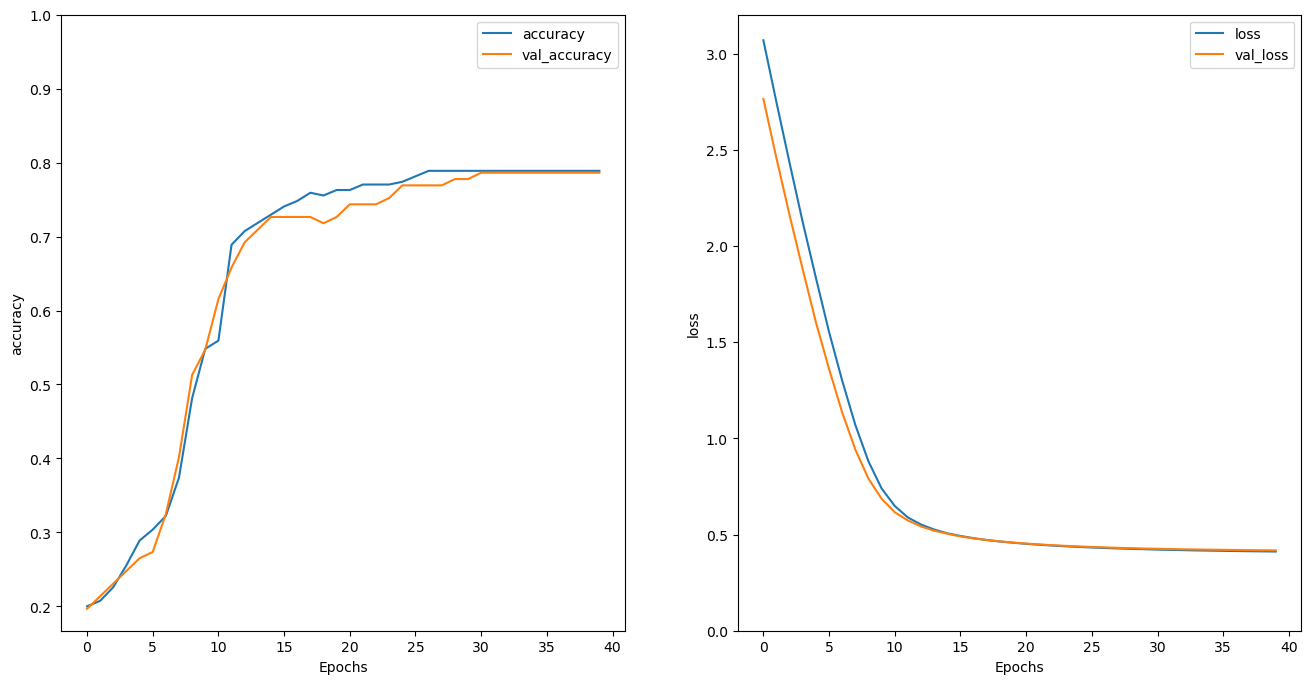

In [23]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)